# Import and misc

In [1]:
# Instal latest torch and torchaudio

In [2]:
from typing import Tuple, Union, List, Callable, Optional
from tqdm import tqdm
from itertools import islice
import pathlib
import dataclasses

import numpy as np
import pandas as pd

import torch
import torch.nn.functional as F
from torch import nn
from torch import distributions
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torch.nn.utils.rnn import pad_sequence
import random
import os

import torchaudio
from IPython import display as display_

from collections import defaultdict
from IPython.display import clear_output
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
# graphics_settings:
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['font.size'] = 12
sns.set_style('darkgrid')

In [4]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
seed_everything()

# Task

In this notebook we will implement a model for finding a keyword in a stream.

We will implement the version with CRNN because it is easy and improves the model. 
(from https://www.dropbox.com/s/22ah2ba7dug6pzw/KWS_Attention.pdf)

In [5]:
@dataclasses.dataclass
class TaskConfig:
    keyword: str = 'sheila'  # We will use 1 key word -- 'sheila'
    batch_size: int = 128
    learning_rate: float = 3e-4
    weight_decay: float = 1e-5
    num_epochs: int = 20
    n_mels: int = 40
    cnn_out_channels: int = 8
    kernel_size: Tuple[int, int] = (5, 20)
    stride: Tuple[int, int] = (2, 8)
    hidden_size: int = 32
    gru_num_layers: int = 2
    bidirectional: bool = False
    num_classes: int = 2
    sample_rate: int = 16000
    device: torch.device = torch.device(
        'cuda:0' if torch.cuda.is_available() else 'cpu')

# Data

In [6]:
!wget http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz -O speech_commands_v0.01.tar.gz
!mkdir speech_commands && tar -C speech_commands -xvzf speech_commands_v0.01.tar.gz 1> log

--2022-11-06 21:29:30--  http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 173.194.210.128, 2607:f8b0:400c:c0f::80
Connecting to download.tensorflow.org (download.tensorflow.org)|173.194.210.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1489096277 (1.4G) [application/gzip]
Saving to: ‘speech_commands_v0.01.tar.gz’

speech_commands_v0. 100%[===================>]   1.39G   194MB/s    in 7.2s    

2022-11-06 21:29:37 (198 MB/s) - ‘speech_commands_v0.01.tar.gz’ saved [1489096277/1489096277]



In [7]:
class SpeechCommandDataset(Dataset):

    def __init__(
        self,
        transform: Optional[Callable] = None,
        path2dir: str = None,
        keywords: Union[str, List[str]] = None,
        csv: Optional[pd.DataFrame] = None
    ):        
        self.transform = transform

        if csv is None:
            path2dir = pathlib.Path(path2dir)
            keywords = keywords if isinstance(keywords, list) else [keywords]
            
            all_keywords = [
                p.stem for p in path2dir.glob('*')
                if p.is_dir() and not p.stem.startswith('_')
            ]

            triplets = []
            for keyword in all_keywords:
                paths = (path2dir / keyword).rglob('*.wav')
                if keyword in keywords:
                    for path2wav in paths:
                        triplets.append((path2wav.as_posix(), keyword, 1))
                else:
                    for path2wav in paths:
                        triplets.append((path2wav.as_posix(), keyword, 0))
            
            self.csv = pd.DataFrame(
                triplets,
                columns=['path', 'keyword', 'label']
            )

        else:
            self.csv = csv
    
    def __getitem__(self, index: int):
        instance = self.csv.iloc[index]

        path2wav = instance['path']
        wav, sr = torchaudio.load(path2wav)
        wav = wav.sum(dim=0)
        
        if self.transform:
            wav = self.transform(wav)

        return {
            'wav': wav,
            'keywors': instance['keyword'],
            'label': instance['label']
        }

    def __len__(self):
        return len(self.csv)

In [8]:
dataset = SpeechCommandDataset(
    path2dir='speech_commands', keywords=TaskConfig.keyword
)

In [9]:
dataset.csv.sample(5)

,path,keyword,label
50866,speech_commands/two/f4cae173_nohash_0.wav,two,0
1003,speech_commands/happy/d3a18257_nohash_1.wav,happy,0
38126,speech_commands/right/471a0925_nohash_0.wav,right,0
144,speech_commands/happy/518588b6_nohash_1.wav,happy,0
31651,speech_commands/go/5588c7e6_nohash_0.wav,go,0


### Augmentations

In [10]:
class AugsCreation:

    def __init__(self):
        self.background_noises = [
            'speech_commands/_background_noise_/white_noise.wav',
            'speech_commands/_background_noise_/dude_miaowing.wav',
            'speech_commands/_background_noise_/doing_the_dishes.wav',
            'speech_commands/_background_noise_/exercise_bike.wav',
            'speech_commands/_background_noise_/pink_noise.wav',
            'speech_commands/_background_noise_/running_tap.wav'
        ]

        self.noises = [
            torchaudio.load(p)[0].squeeze()
            for p in self.background_noises
        ]

    def add_rand_noise(self, audio):

        # randomly choose noise
        noise_num = torch.randint(low=0, high=len(
            self.background_noises), size=(1,)).item()
        noise = self.noises[noise_num]

        noise_level = torch.Tensor([1])  # [0, 40]

        noise_energy = torch.norm(noise)
        audio_energy = torch.norm(audio)
        alpha = (audio_energy / noise_energy) * \
            torch.pow(10, -noise_level / 20)

        start = torch.randint(
            low=0,
            high=max(int(noise.size(0) - audio.size(0) - 1), 1),
            size=(1,)
        ).item()
        noise_sample = noise[start: start + audio.size(0)]

        audio_new = audio + alpha * noise_sample
        audio_new.clamp_(-1, 1)
        return audio_new

    def __call__(self, wav):
        aug_num = torch.randint(low=0, high=4, size=(1,)).item()   # choose 1 random aug from augs
        augs = [
            lambda x: x,
            lambda x: (x + distributions.Normal(0, 0.01).sample(x.size())).clamp_(-1, 1),
            lambda x: torchaudio.transforms.Vol(.25)(x),
            lambda x: self.add_rand_noise(x)
        ]

        return augs[aug_num](wav)

In [11]:
indexes = torch.randperm(len(dataset))
train_indexes = indexes[:int(len(dataset) * 0.8)]
val_indexes = indexes[int(len(dataset) * 0.8):]

train_df = dataset.csv.iloc[train_indexes].reset_index(drop=True)
val_df = dataset.csv.iloc[val_indexes].reset_index(drop=True)

In [12]:
# Sample is a dict of utt, word and label
train_set = SpeechCommandDataset(csv=train_df, transform=AugsCreation())
val_set = SpeechCommandDataset(csv=val_df)

In [13]:
train_set[0]

{'wav': tensor([0.0077, 0.0075, 0.0076,  ..., 0.0239, 0.0229, 0.0204]),
 'keywors': 'six',
 'label': 0}

### Sampler for oversampling:

In [14]:
# We should provide to WeightedRandomSampler _weight for every sample_; by default it is 1/len(target)

def get_sampler(target):
    class_sample_count = np.array(
        [len(np.where(target == t)[0]) for t in np.unique(target)])   # for every class count it's number of occ.
    weight = 1. / class_sample_count
    samples_weight = np.array([weight[t] for t in target])
    samples_weight = torch.from_numpy(samples_weight)
    samples_weigth = samples_weight.float()
    sampler = WeightedRandomSampler(samples_weight, len(samples_weight))
    return sampler

In [15]:
train_sampler = get_sampler(train_set.csv['label'].values)

In [16]:
class Collator:
    
    def __call__(self, data):
        wavs = []
        labels = []    

        for el in data:
            wavs.append(el['wav'])
            labels.append(el['label'])

        # torch.nn.utils.rnn.pad_sequence takes list(Tensors) and returns padded (with 0.0) Tensor
        wavs = pad_sequence(wavs, batch_first=True)    
        labels = torch.Tensor(labels).long()
        return wavs, labels

###  Dataloaders

In [17]:
# Here we are obliged to use shuffle=False because of our sampler with randomness inside.

train_loader = DataLoader(train_set, batch_size=TaskConfig.batch_size,
                          shuffle=False, collate_fn=Collator(),
                          sampler=train_sampler, pin_memory=True)

val_loader = DataLoader(val_set, batch_size=TaskConfig.batch_size,
                        shuffle=False, collate_fn=Collator(), pin_memory=True)

### Creating MelSpecs on GPU for speeeed: 

In [18]:
class LogMelspec:

    def __init__(self, is_train, config):
        # with augmentations
        if is_train:
            self.melspec = nn.Sequential(
                torchaudio.transforms.MelSpectrogram(
                    sample_rate=config.sample_rate,
                    n_fft=400,
                    win_length=400,
                    hop_length=160,
                    n_mels=config.n_mels
                ),
                torchaudio.transforms.FrequencyMasking(freq_mask_param=15),
                torchaudio.transforms.TimeMasking(time_mask_param=35),
            ).to(config.device)

        # no augmentations
        else:
            self.melspec = torchaudio.transforms.MelSpectrogram(
                sample_rate=config.sample_rate,
                n_fft=400,
                win_length=400,
                hop_length=160,
                n_mels=config.n_mels
            ).to(config.device)

    def __call__(self, batch):
        # already on device
        return torch.log(self.melspec(batch).clamp_(min=1e-9, max=1e9))

In [19]:
melspec_train = LogMelspec(is_train=True, config=TaskConfig)
melspec_val = LogMelspec(is_train=False, config=TaskConfig)

### Quality measurment functions:

In [20]:
# FA - true: 0, model: 1
# FR - true: 1, model: 0

def count_FA_FR(preds, labels):
    FA = torch.sum(preds[labels == 0])
    FR = torch.sum(labels[preds == 0])
    
    # torch.numel - returns total number of elements in tensor
    return FA.item() / torch.numel(preds), FR.item() / torch.numel(preds)

In [21]:
def get_au_fa_fr(probs, labels):
    sorted_probs, _ = torch.sort(probs)
    sorted_probs = torch.cat((torch.Tensor([0]), sorted_probs, torch.Tensor([1])))
    labels = torch.cat(labels, dim=0)
        
    FAs, FRs = [], []
    for prob in sorted_probs:
        preds = (probs >= prob) * 1
        FA, FR = count_FA_FR(preds, labels)        
        FAs.append(FA)
        FRs.append(FR)
    # plt.plot(FAs, FRs)
    # plt.show()

    # ~ area under curve using trapezoidal rule
    return -np.trapz(FRs, x=FAs)

# Model

In [22]:
class Attention(nn.Module):

    def __init__(self, hidden_size: int):
        super().__init__()

        self.energy = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )
    
    def forward(self, input):
        energy = self.energy(input)
        alpha = torch.softmax(energy, dim=-2)
        return (input * alpha).sum(dim=-2)

class CRNN(nn.Module):

    def __init__(self, config: TaskConfig):
        super().__init__()
        self.config = config

        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=config.cnn_out_channels,
                kernel_size=config.kernel_size, stride=config.stride
            ),
            nn.Flatten(start_dim=1, end_dim=2),
        )

        self.conv_out_frequency = (config.n_mels - config.kernel_size[0]) // \
            config.stride[0] + 1
        
        self.gru = nn.GRU(
            input_size=self.conv_out_frequency * config.cnn_out_channels,
            hidden_size=config.hidden_size,
            num_layers=config.gru_num_layers,
            dropout=0.1,
            bidirectional=config.bidirectional,
            batch_first=True
        )

        self.attention = Attention(config.hidden_size)
        self.classifier = nn.Linear(config.hidden_size, config.num_classes)
    
    def forward(self, input):
        input = input.unsqueeze(dim=1)
        conv_output = self.conv(input).transpose(-1, -2)
        gru_output, _ = self.gru(conv_output)
        contex_vector = self.attention(gru_output)
        output = self.classifier(contex_vector)
        return output

In [23]:
def train_epoch(model, opt, loader, log_melspec, device):
    model.train()
    losses = []
    for i, (batch, labels) in tqdm(enumerate(loader), total=len(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        opt.zero_grad()

        # run model # with autocast():
        logits = model(batch)
        # we need probabilities so we use softmax & CE separately
        probs = F.softmax(logits, dim=-1)
        loss = F.cross_entropy(logits, labels)

        loss.backward()
        losses.append(loss.cpu().detach().numpy())
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)

        opt.step()

    return np.mean(losses)

In [24]:
@torch.no_grad()
def validation(model, loader, log_melspec, device):
    model.eval()

    val_losses, accs, FAs, FRs = [], [], [], []
    all_probs, all_labels = [], []
    for i, (batch, labels) in tqdm(enumerate(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        output = model(batch)
        # we need probabilities so we use softmax & CE separately
        probs = F.softmax(output, dim=-1)
        
        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        all_probs.append(probs[:, 1].cpu())
        all_labels.append(labels.cpu())
        accs.append(
            torch.sum(argmax_probs == labels).item() /  # ???
            torch.numel(argmax_probs)
        )
        FA, FR = count_FA_FR(argmax_probs, labels)
        FAs.append(FA)
        FRs.append(FR)

    # area under FA/FR curve for whole loader
    au_fa_fr = get_au_fa_fr(torch.cat(all_probs, dim=0).cpu(), all_labels)
    return au_fa_fr

In [25]:
history = defaultdict(list)

# Training

In [26]:
config = TaskConfig()
model = CRNN(config).to(config.device)
model

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 32, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): Tanh()
      (2): Linear(in_features=32, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=32, out_features=2, bias=True)
)

In [27]:
opt = torch.optim.Adam(
    model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

In [28]:
sum([p.numel() for p in model.parameters()])

25387

In [29]:
def classification(model, opt, train_loader, melspec_train, val_loader, melspec_val, config):
    for n in range(1, config.num_epochs + 1):

        train_loss = train_epoch(model, opt, train_loader,
                    melspec_train, config.device)

        au_fa_fr = validation(model, val_loader,
                              melspec_val, config.device)
        history['val_metric'].append(au_fa_fr)
        history['train_loss'].append(train_loss)

        clear_output()
        fig, ax = plt.subplots(1, 2, figsize=(12,6))

        ax[0].plot(history['val_metric'], color="#67E46F") 
        ax[1].plot(history['train_loss'], color="#CB60D3") 
        
        ax[0].set_ylabel('Validation Metric')
        ax[0].set_xlabel('Epoch')
        ax[1].set_ylabel('Train CE Loss')
        ax[1].set_xlabel('Epoch')
        plt.show()

        print("CURRENT EPOCH: ", n)
        print("CURRENT LOSS: ", history['train_loss'][-1])
        print("CURRENT METRIC: ", history['val_metric'][-1])
        print("MIN METRIC: ", min(history['val_metric']))
        print("DIFFERENCE: ", min(history['val_metric']) - 5.5 * 1e-5)
        if min(history['val_metric']) < 5.5 * 1e-5:
            print("YOU HAVE ALREADY WON")
        else:
            print("LETS WAIT")

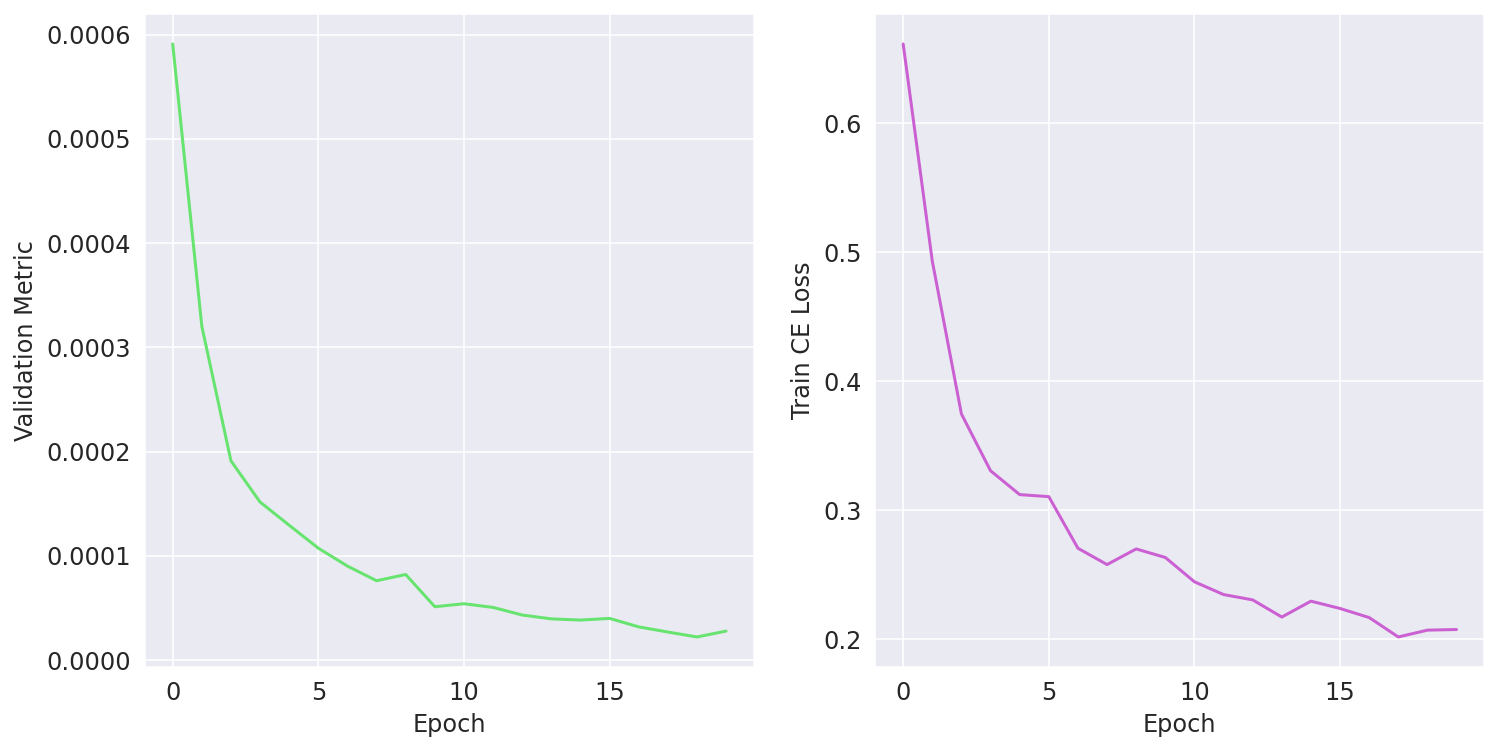

CURRENT EPOCH:  20
CURRENT LOSS:  0.2074377
CURRENT METRIC:  2.7737161157053765e-05
MIN METRIC:  2.2103796240474862e-05
DIFFERENCE:  -3.289620375952514e-05
YOU HAVE ALREADY WON


In [30]:
classification(model, opt, train_loader, melspec_train, val_loader, melspec_val, config)

# Reproduce

**You can run the code below to see if the results are reproducible.**

In [31]:
"""
history = defaultdict(list)
config = TaskConfig()
model = CRNN(config).to(config.device)

print(model)

opt = torch.optim.Adam(
    model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

classification(model, opt, train_loader, melspec_train, val_loader, melspec_val, config)"""

'\nhistory = defaultdict(list)\nconfig = TaskConfig()\nmodel = CRNN(config).to(config.device)\n\nprint(model)\n\nopt = torch.optim.Adam(\n    model.parameters(),\n    lr=config.learning_rate,\n    weight_decay=config.weight_decay\n)\n\nclassification(model, opt, train_loader, melspec_train, val_loader, melspec_val, config)'

# Utils

**Let's write some auxiliary functions: measuring the speed of the model, memory and comparing two models.**

In [32]:
import tempfile

def get_size_in_megabytes(model):
    # https://pytorch.org/tutorials/recipes/recipes/dynamic_quantization.html#look-at-model-size
    with tempfile.TemporaryFile() as f:
        torch.save(model.state_dict(), f)
        size = f.tell() / 2**20
    return size

In [33]:
# random 2 seconds wav for testing
random_wav = torch.randn(1, 2 * 16_000).to(config.device)
melspec_flops = LogMelspec(is_train=False, config=config)
random_spec = melspec_flops(random_wav)
random_spec.shape

torch.Size([1, 40, 201])

In [37]:
#!pip install thop

In [38]:
from thop import profile  
import copy

def get_flops(model):        
    return profile(copy.deepcopy(model), (random_spec, ), verbose=False)  # -> (6.0 MACs, 3.0 parameters)

In [39]:
def compare_models(model_student, model_teacher, quantize=False):
    print("STUDENT SMALLER THAN TEACHER IN ", get_size_in_megabytes(model_teacher) / get_size_in_megabytes(model_student), "TIMES")
    if not quantize:
      print("STUDENT FASTER THAN TEACHER IN ", get_flops(model_teacher)[0] / get_flops(model_student)[0], "TIMES")

# Distillation.

**As a first experiment, let's try to distillate the model. Reduce the hidden size to 24, halve the number of channels and GRU layers. Increase the stride into convolutions, which will greatly increase the speed of work.**

In [43]:
history = defaultdict(list)
config_student = TaskConfig(hidden_size=24, cnn_out_channels=4, num_epochs=50, gru_num_layers=1, stride=(4, 12))
model_student = CRNN(config_student).to(config_student.device)
model_teacher = copy.deepcopy(model)

In [44]:
compare_models(model_student, model_teacher)

STUDENT SMALLER THAN TEACHER IN  4.189666732399921 TIMES
STUDENT FASTER THAN TEACHER IN  6.399320882852292 TIMES


In [45]:
opt = torch.optim.Adam(
    model_student.parameters(),
    lr=config_student.learning_rate,
    weight_decay=config_student.weight_decay
)

**We shrunk the model several times both in terms of memory and speed, which is not bad for a start. Let's try to train 40 epochs (since the model is smaller, it needs more time to train than a large model).**

In [46]:
def distillation_train_epoch(model_student, model_teacher, opt, loader, log_melspec, device):
    model_student.train()
    model_teacher.eval()
    losses = []
    for i, (batch, labels) in tqdm(enumerate(loader), total=len(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        opt.zero_grad()

        # run model # with autocast():
        with torch.inference_mode():
            logits_teacher = model_teacher(batch)
    
        logits_student = model_student(batch)
        # we need probabilities so we use softmax & CE separately
        probs_student, probs_teacher = F.log_softmax(logits_student, dim=-1), F.softmax(logits_teacher, dim=-1)
        loss_distillation = nn.KLDivLoss(reduction='batchmean')

        a = F.cross_entropy(logits_student, labels)
        b = loss_distillation(probs_student, probs_teacher)
        
        loss = a + b
        losses.append((a.detach().cpu().numpy(), b.detach().cpu().numpy()))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model_student.parameters(), 5)

        logits_student = model_student(batch)
        opt.step()


    return np.array(losses).mean(axis=0)

In [75]:
def distillation_classification(model_student, model_teacher, opt, train_loader, melspec_train, val_loader, melspec_val, config_student):
    for n in range(1, config_student.num_epochs + 1):
        train_loss = distillation_train_epoch(model_student, model_teacher, opt, train_loader,
                melspec_train, config_student.device)

        au_fa_fr = validation(model_student, val_loader,
                              melspec_val, config_student.device)
        history['val_metric'].append(au_fa_fr)
        history['train_loss'].append(train_loss)

        clear_output()
        fig, ax = plt.subplots(1, 3, figsize=(18,6))

        ax[0].plot(history['val_metric'], color="#67E46F") 
        ax[1].plot([f[0] for f in history['train_loss']], color="#CB60D3")
        ax[2].plot([f[1] for f in history['train_loss']], color="#64AAD0")
        
        ax[0].set_ylabel('Validation Metric')
        ax[0].set_xlabel('Epoch')
        ax[1].set_ylabel('Train KL Loss')
        ax[1].set_xlabel('Epoch')
        ax[2].set_ylabel('Train CE Loss')
        ax[2].set_xlabel('Epoch')
        plt.show()

        print("CURRENT EPOCH: ", n)
        print("CURRENT KL LOSS: ", history['train_loss'][-1][0])
        print("CURRENT CE LOSS: ", history['train_loss'][-1][1])
        print("CURRENT METRIC: ", history['val_metric'][-1])
        print("MIN METRIC: ", min(history['val_metric']))
        print("DIFFERENCE: ", min(history['val_metric']) - 5.5 * 1e-5)
        if min(history['val_metric']) < 5.5 * 1e-5:
            print("YOU HAVE ALREADY WON")
        else:
            print("LETS WAIT")

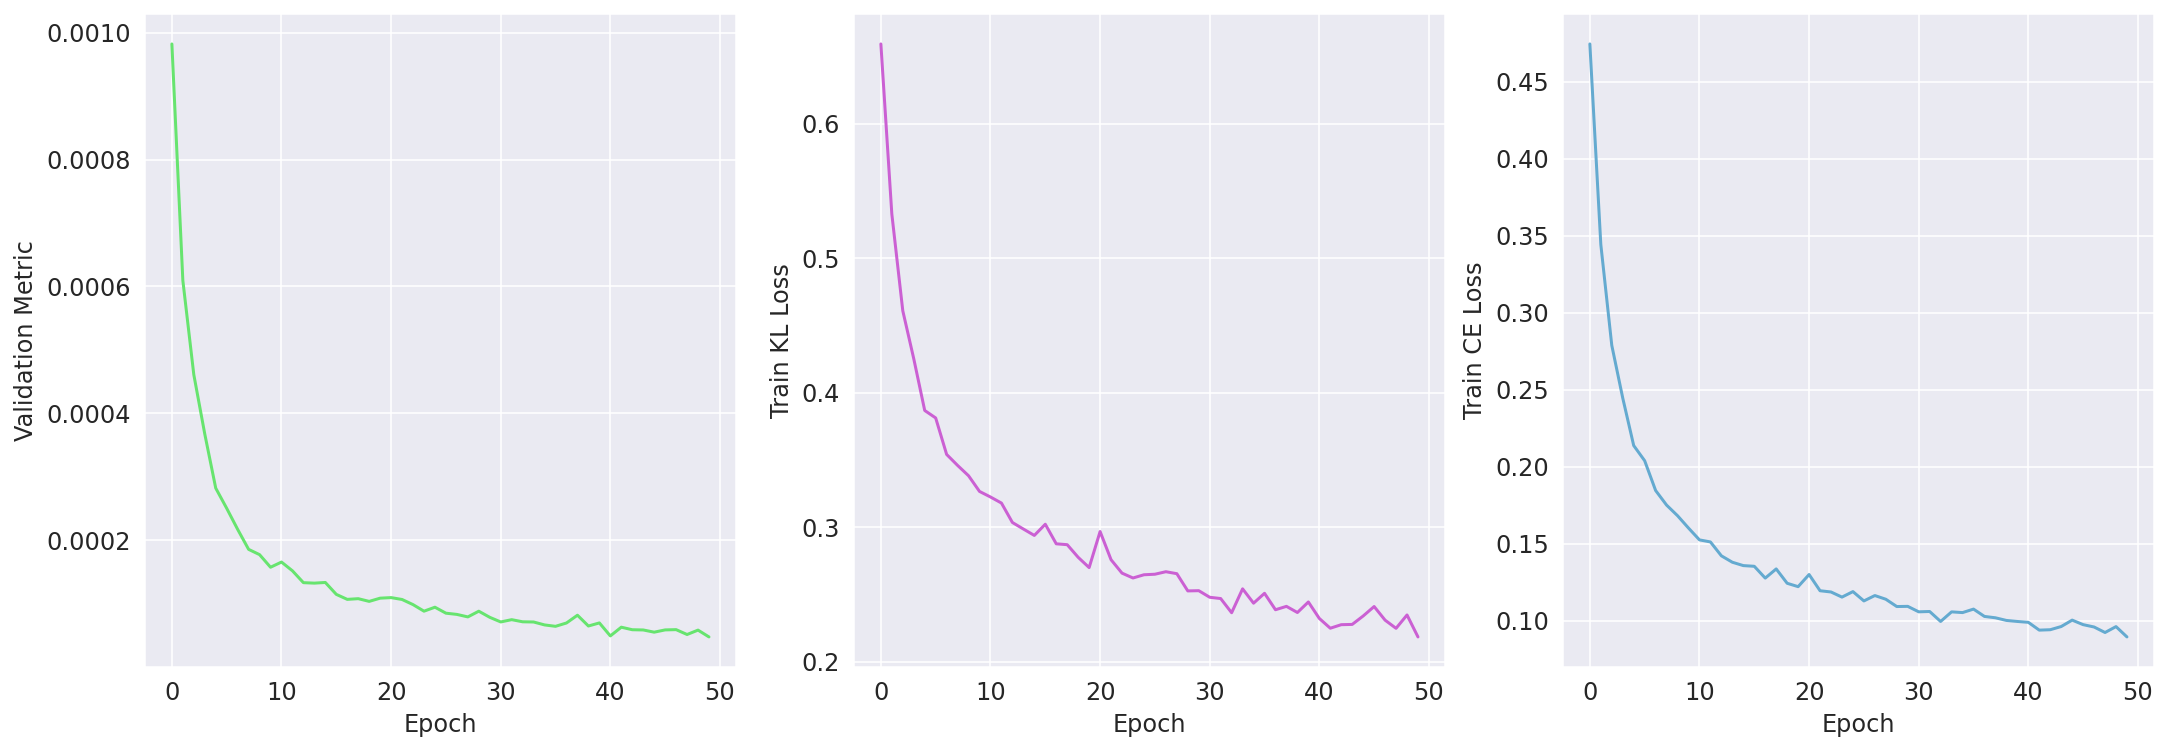

CURRENT EPOCH:  50
CURRENT KL LOSS:  0.21832027
CURRENT CE LOSS:  0.089541346
CURRENT METRIC:  4.748377610298555e-05
MIN METRIC:  4.748377610298555e-05
DIFFERENCE:  -7.5162238970144545e-06
YOU HAVE ALREADY WON


In [52]:
distillation_classification(model_student, model_teacher, opt, train_loader, melspec_train, val_loader, melspec_val, config_student)

**As we can see, we were able to achieve the desired quality after 100 epochs (and a smaller number of epochs would not have been enough for us). Interestingly, decreasing the learning rate doesn't help reduce training noise: I used an exponential scheduler every 5 epochs, but that didn't help.**

# Fp32 -> Fp16

**Let's try to make compression in the simplest form: just replace float32 with float16.**

In [53]:
# redefine meplspec class for fp16 calculations
class LogMelspecCompress(LogMelspec):
    def __call__(self, batch):
        return torch.log(self.melspec(batch).clamp_(min=1e-3, max=1e3).half())

In [65]:
history = defaultdict(list)
config_comp = TaskConfig(weight_decay=1e-3, learning_rate=4e-3)
model_comp = CRNN(config_comp).to(config_comp.device).half()
compare_models(model_comp, model, quantize=True)

STUDENT SMALLER THAN TEACHER IN  1.9360556262564783 TIMES


In [57]:
melspec_train_comp = LogMelspecCompress(is_train=True, config=config_comp)
melspec_val_comp = LogMelspecCompress(is_train=False, config=config_comp)

In [58]:
opt = torch.optim.Adam(
    model_comp.parameters(),
    lr=config_comp.learning_rate,
    weight_decay=config_comp.weight_decay,
    eps=1e-3
)

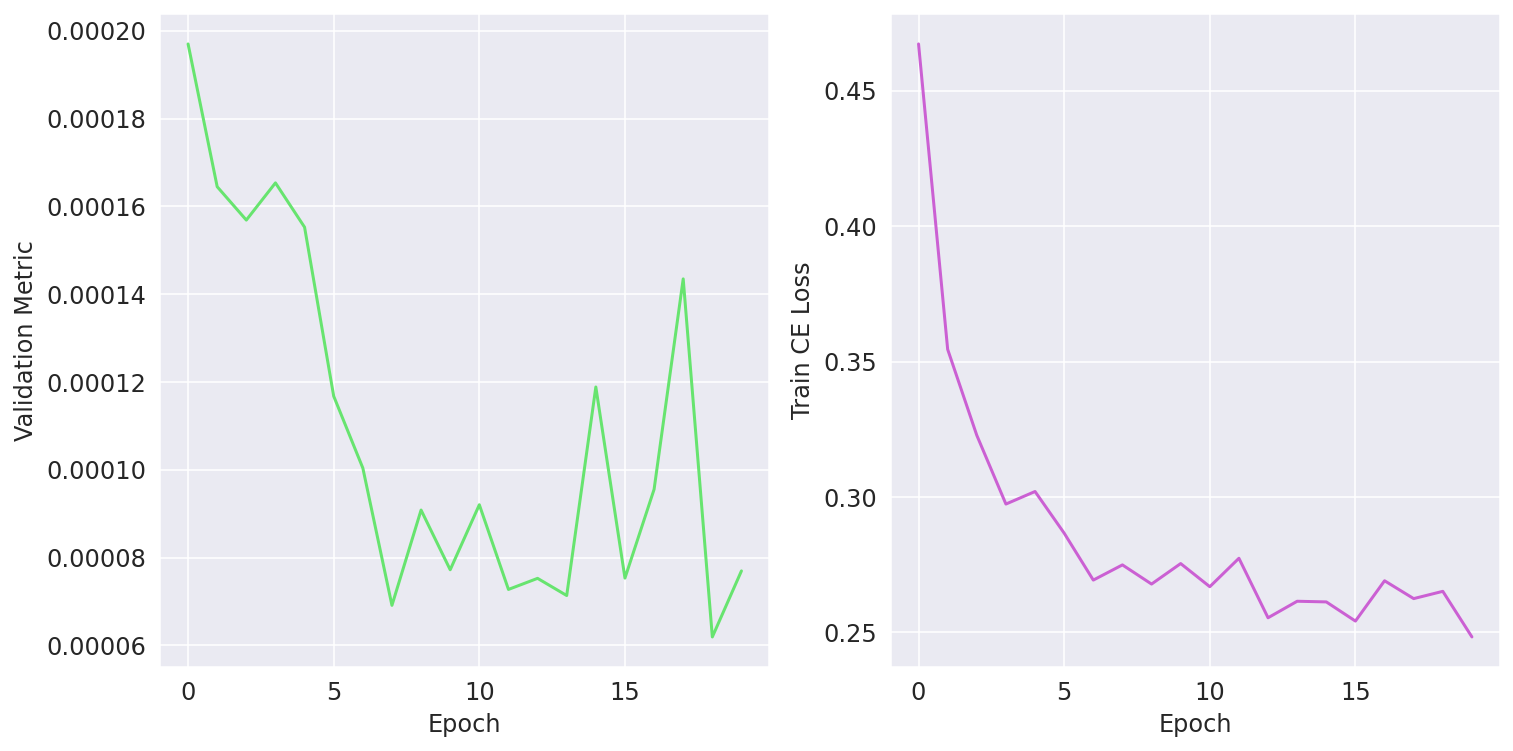

CURRENT EPOCH:  20
CURRENT LOSS:  0.2483
CURRENT METRIC:  7.695749360614575e-05
MIN METRIC:  6.190137105897564e-05
DIFFERENCE:  6.901371058975633e-06
LETS WAIT


In [59]:
classification(model_comp, opt, train_loader, melspec_train_comp, val_loader, melspec_val_comp, config_comp)

# Final setup

**Let's combine distillation and replacement of float32 with float16 together.**

In [68]:
history = defaultdict(list)
config_student_comp = TaskConfig(hidden_size=24, cnn_out_channels=4, num_epochs=20, gru_num_layers=1, stride=(4, 12), weight_decay=1e-3, learning_rate=4e-3)
model_student_comp = CRNN(config_student_comp).to(config_student_comp.device).half()
compare_models(model_student_comp, model_teacher, quantize=True)

STUDENT SMALLER THAN TEACHER IN  7.31658186380428 TIMES


In [61]:
model_teacher_comp = model_teacher.half()

In [69]:
opt = torch.optim.Adam(
    model_student_comp.parameters(),
    lr=config_student_comp.learning_rate,
    weight_decay=config_student_comp.weight_decay,
    eps=1e-3
)

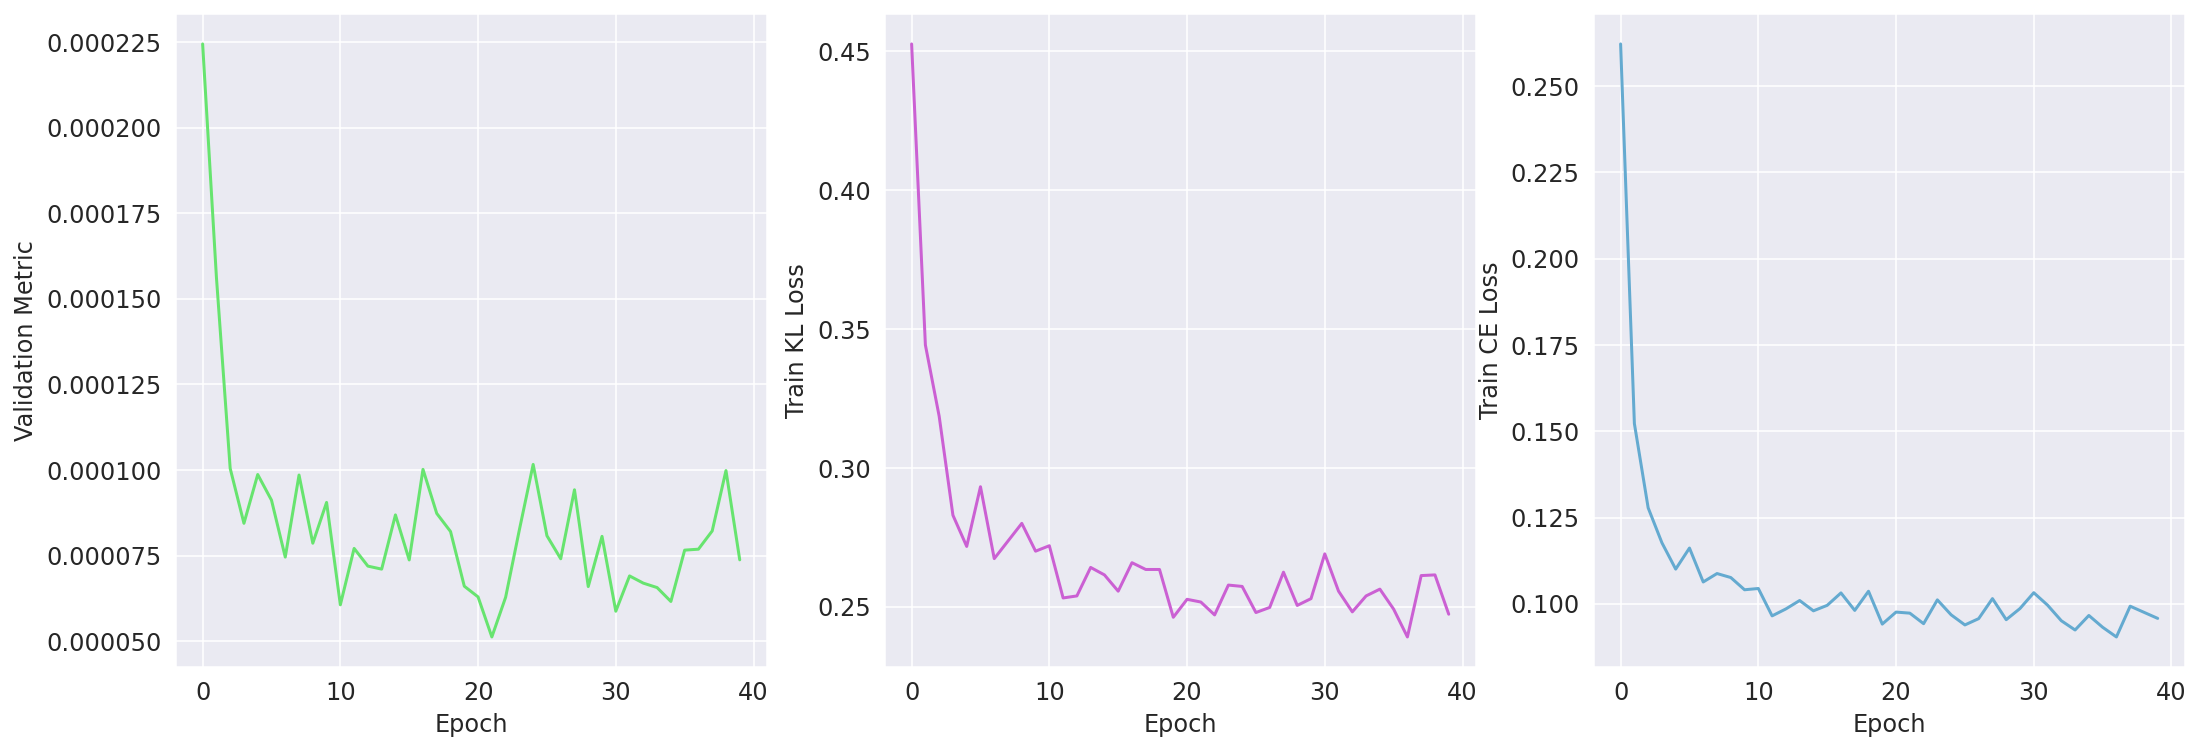

CURRENT EPOCH:  40
CURRENT KL LOSS:  0.2473
CURRENT CE LOSS:  0.09576
CURRENT METRIC:  7.378574206677955e-05
MIN METRIC:  5.127316881699784e-05
DIFFERENCE:  -3.726831183002164e-06
YOU HAVE ALREADY WON


In [76]:
distillation_classification(model_student_comp, model_teacher_comp, opt, train_loader, melspec_train_comp, val_loader, melspec_val_comp, config_student_comp)